In [70]:
##Importing required libraries##
import pandas as pd
import arff
import matplotlib.pyplot as plt
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import Image 
from sklearn.externals.six import StringIO
from sklearn import tree
import pydot 
from pandas.tools.plotting import scatter_matrix
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Problem 1

In [2]:
##loading the data into a DataFrame##
data = arff.load(open('weather.numeric.arff'))
cols = [col[0] for col in data['attributes']]
weather_DF = pd.DataFrame(data['data'], columns=cols)
weather_DF

,outlook,temperature,humidity,windy,play
0,sunny,85,85,FALSE,no
1,sunny,80,90,TRUE,no
2,overcast,83,86,FALSE,yes
3,rainy,70,96,FALSE,yes
4,rainy,68,80,FALSE,yes
5,rainy,65,70,TRUE,no
6,overcast,64,65,TRUE,yes
7,sunny,72,95,FALSE,no
8,sunny,69,70,FALSE,yes
9,rainy,75,80,FALSE,yes


In [3]:
##Calculate the mean temperature and mean humidity##
mean_temp = weather_DF['temperature'].mean()
mean_humi = weather_DF['humidity'].mean()
print "mean temprature is", mean_temp
print "mean humidity is", mean_humi

mean temprature is 73.5714285714
mean humidity is 81.6428571429


In [5]:
##Printing outlook and play for those days where the temperature is greater than the average temperature##
weather_DF.ix[weather_DF['temperature']>mean_temp][['outlook','play']]

,outlook,play
0,sunny,no
1,sunny,no
2,overcast,yes
9,rainy,yes
10,sunny,yes
12,overcast,yes


In [6]:
##Printing outlook and play for those days where the humidity is greater than the average humidity##
weather_DF.ix[weather_DF['humidity']>mean_humi][['outlook','play']]

,outlook,play
0,sunny,no
1,sunny,no
2,overcast,yes
3,rainy,yes
7,sunny,no
11,overcast,yes
13,rainy,no


In [7]:
##Converting the temperature to Celsius as a new column##
weather_DF['temperature_celsius']=(weather_DF['temperature']-32)*(5./9)
weather_DF

,outlook,temperature,humidity,windy,play,temperature_celsius
0,sunny,85,85,FALSE,no,29.444444
1,sunny,80,90,TRUE,no,26.666667
2,overcast,83,86,FALSE,yes,28.333333
3,rainy,70,96,FALSE,yes,21.111111
4,rainy,68,80,FALSE,yes,20.000000
5,rainy,65,70,TRUE,no,18.333333
6,overcast,64,65,TRUE,yes,17.777778
7,sunny,72,95,FALSE,no,22.222222
8,sunny,69,70,FALSE,yes,20.555556
9,rainy,75,80,FALSE,yes,23.888889


In [10]:
##1.How often do you play tennis independent of the other attributes?##
print 'playing tennis', weather_DF.ix[weather_DF['play']=='yes']['play'].count(), "out of", weather_DF.shape[0], "days"

playing tennis 9 out of 14 days


In [9]:
##2.How often do you play tennis when it is "sunny"?##
print ('playing tennis', weather_DF.ix[weather_DF['outlook']=='sunny'].ix[weather_DF['play']=='yes']['play'].count(),\
       "out of", weather_DF.shape[0], "days, when it is sunny")

('playing tennis', 2, 'out of', 14, 'days, when it is sunny')


In [9]:
##3.Compare the average, minimum and maximum temperature when you play tennis?##
weather_DF.ix[weather_DF['play']=='yes']['temperature'].describe()[['mean','min','max']]

mean    73
min     64
max     83
Name: temperature, dtype: float64

In [11]:
##4.Compare the average, minimum and maximum humidity when you play tennis?##
weather_DF.ix[weather_DF['play']=='yes']['humidity'].describe()[['mean','min','max']]

mean    79.111111
min     65.000000
max     96.000000
Name: humidity, dtype: float64

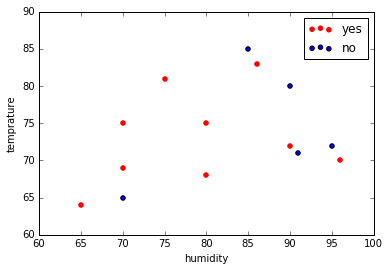

In [11]:
##5.Plot the an scatter plot of humidity and temperature when you play tennis compared to when you do not play tennis##
plt.scatter(weather_DF.ix[weather_DF['play']=='yes']['humidity'],weather_DF.ix[weather_DF['play']=='yes']\
            ['temperature'], label='yes', color='r')
plt.scatter(weather_DF.ix[weather_DF['play']=='no']['humidity'],weather_DF.ix[weather_DF['play']=='no']\
            ['temperature'],label='no')
plt.legend()
plt.xlabel('humidity')
plt.ylabel('temprature')

# Problem 2 

**What problems did you have to deal with when working with these files?**

1. Each file had some sort of explanation in the header which needed to be removed. Different files had different header formats and this made it hard to have one single parsing script to remove all at once and had to do 5 different type of parsing for these files.
2. There was space at the end of each file which needed to be removed.
3. There was space in the second row (after the first row of useful data) which needed to be removed.
4. There were duplicate data (years) columns after 1960, so needed to remove in one of the files which had duplicated.
5. Each file has different formats of headers.
6. st5060ts.txt had mixed months and year format which needed to be parsed. It also had two columns for 1950 (I used averaging to get one single 1950 column)
7. some of the files had integers seperated by commas (,) which needed to be removed and convert to integer for numerical operations.
8. Date formats were different across files and they needed to be unified.
9. Name of states column had different format across different files. For example US versus U.S.. They needed to be unified.
10. After importing all parsed data files to DataFrame, they needed to be attached together on the first common column.
11. There were NaN values (no population number available for some of the states in some of the years) which needed to be filled in.

In [12]:
##parsing each text files and loading them into DataFrame##
data_Df=pd.DataFrame()
data_Df['region']={}
for fn in os.listdir('/Users/phesami/Documents/DSE/phesami/DSE220/Data/'):
    file_path='/Users/phesami/Documents/DSE/phesami/DSE220/Data/'+fn
    if fn.endswith('9ts.txt'):
        ##removing the header text##
        !cat {file_path} | sed -e '1,/The figures/d'>temp.txt
        ##reading the text file with no header, removing the cpace rows (with all NaN), and naming the first column##
        temp_DF=pd.read_fwf('temp.txt', header=1).dropna(axis=0, thresh=11).rename(columns={'Unnamed: 0': 'region'})
        ##Removing the commas and converting all numbers to integer type for numerical operations###
        temp_DF=temp_DF.replace(to_replace=',', value='', regex=True).convert_objects(convert_numeric=True)
        ##removing the (.) in the names and converting them to uppercase for unifications##
        temp_DF['region']=temp_DF['region'].str.replace('.','').str.upper()
        ##merginf the DataFrame with the existing DataFrame of other files##
        data_Df=pd.merge(data_Df,temp_DF, how='outer', on='region')
    elif fn.endswith('60ts.txt'):
        !cat {file_path} | sed -e '1,/estimates\./d'>temp.txt
        temp_DF=pd.read_fwf('temp.txt', header=4).dropna(axis=0, thresh=11).rename(columns={'(census).1': '1960',\
                                                                                         'Unnamed: 0': 'region'})
        temp_DF=temp_DF.replace(to_replace=',', value='', regex=True).convert_objects(convert_numeric=True)
        temp_DF['region']=temp_DF['region'].str.replace('.','').str.upper()
        temp_DF['1950']=(temp_DF['1950']+temp_DF['(census)'])/2
        temp_DF.drop(['(census)','1960'], axis=1, inplace=True)
        data_Df=pd.merge(data_Df,temp_DF, how='outer', on='region')
    elif fn.endswith('70ts.txt'):
        !cat {file_path} | sed -e '1,/To obtain/d'>temp.txt
        temp_DF=pd.read_fwf('temp.txt', header=4).dropna(axis=0, thresh=11).rename(columns={'(census).1': '1960',\
                                                                                            'Unnamed: 0': 'region'})
        temp_DF=temp_DF.replace(to_replace=',', value='', regex=True).convert_objects(convert_numeric=True)
        temp_DF['region']=temp_DF['region'].str.replace('.','').str.upper()
        temp_DF['1960']=(temp_DF['1960']+temp_DF['1960.1'])/2
        temp_DF.drop(['1960.1','1970'], axis=1, inplace=True)
        data_Df=pd.merge(data_Df,temp_DF, how='outer', on='region')
    elif fn.endswith('80ts.txt'):
        !cat {file_path} | sed -e '1,/remaining/d'>temp.txt
        temp_DF=pd.read_fwf('temp.txt', header=1).dropna(axis=0, thresh=11)
        temp_DF.drop('Fip', axis=1, inplace=True)
        temp_DF.columns=range(1969,1981)
        temp_DF=temp_DF.rename(columns={1969: 'region'}).convert_objects(convert_numeric=True)
        temp_DF['region']=temp_DF['region'].str.replace('.','').str.upper()
        temp_DF.drop([1980], axis=1, inplace=True)
        data_Df=pd.merge(data_Df,temp_DF, how='outer', on='region')
    elif fn.endswith('90ts.txt'):
        !cat {file_path} | sed -e '1,/Table/d'>temp.txt
        temp_DF=pd.read_fwf('temp.txt', header=1).dropna(axis=0, thresh=11)
        temp_DF.columns=range(1979,1991)
        temp_DF=temp_DF.rename(columns={1979: 'region'}).convert_objects(convert_numeric=True)
        temp_DF['region']=temp_DF['region'].str.replace('.','').str.upper()
        data_Df=pd.merge(data_Df,temp_DF, how='outer', on='region')

##changing the columns to numeric values that can be used later for plotting##
data_Df.columns=range(1899,1991)
data_Df=data_Df.rename(columns={1899: 'region'})
data_Df.head()

,region,1900,1901,1902,1903,1904,1905,1906,1907,1908,...,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
0,US,76094,77585,79160,80632,82165,83820,5437,87000,88709,...,229465714,231664458,233791994,235824902,237923795,240132887,242288918,244498982,246819230,248709873
1,NORTHEAST,21059,21401,21815,22248,22716,23214,3769,24320,24879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NORTH CENTRAL,26359,26722,27126,27446,27830,28203,8524,28868,29187,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SOUTH,24565,25114,25599,26055,26492,27003,7475,27879,28406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WEST,4112,4351,4620,4882,5127,5398,5671,5934,6234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


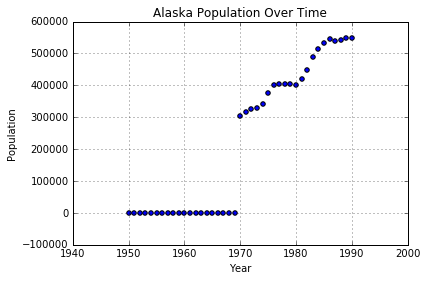

In [17]:
##Plot the populations of Alaska over time##
plt.scatter(data_Df.ix[data_Df['region']=='AK'].ix[:,1:].columns,data_Df.ix[data_Df['region']=='AK'].ix[:,1:])
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Alaska Population Over Time')
plt.grid()

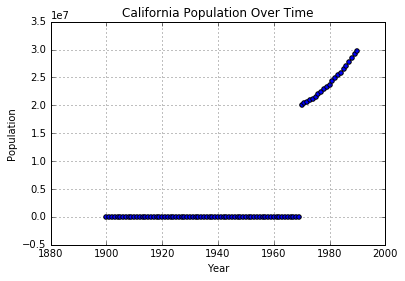

In [18]:
##Plot the populations of California over time##
plt.scatter(data_Df.ix[data_Df['region']=='CA'].ix[:,1:].columns,data_Df.ix[data_Df['region']=='CA'].ix[:,1:])
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('California Population Over Time')
plt.grid()

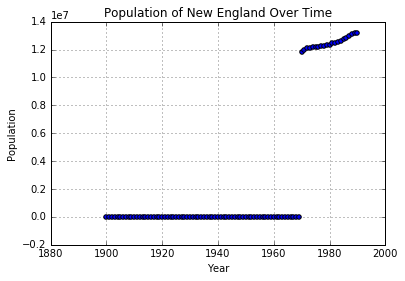

In [19]:
##Plot the population of New England over time##
data_df_NewEngland=pd.DataFrame()
for st in ['ME', 'VT', 'NH', 'MA', 'RI', 'CT']:
    data_df_NewEngland=data_df_NewEngland.add(data_Df.ix[data_Df['region']==st].ix[:,1:],fill_value=0)
plt.scatter(data_df_NewEngland.sum(axis=0).keys(),data_df_NewEngland.sum(axis=0))
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population of New England Over Time')
plt.grid()

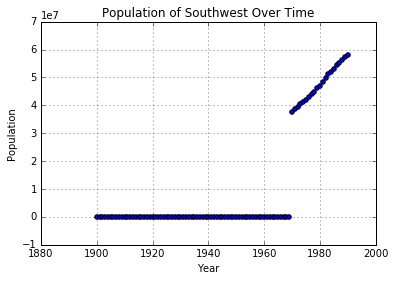

In [21]:
##lot the population of Southwest over time##
data_df_SouthEast=pd.DataFrame()
for st in ['AZ', 'CA', 'CO', 'NV', 'NM', 'TX', 'UT']:
    data_df_SouthEast=data_df_SouthEast.add(data_Df.ix[data_Df['region']==st].ix[:,1:],fill_value=0)
plt.scatter(data_df_SouthEast.sum(axis=0).keys(),data_df_SouthEast.sum(axis=0))
plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Population of Southwest Over Time')
plt.grid()

**What state showed the greatest change in population?**

I approached this with the following 4 different interpretations:

1. Greatest change year over year in one single year. i.e., greatest stantaneous change in a single year compared to the year before.
2. Greatest change year over year averaged over all years.
3. Greatest change comparing year 1990 to year 1900 (or the closest year where population numbers is available).

**In all of these three approaches, we can compare either absulte or percentage change. I have done both and hence in total there are 6 different approaches presented here:**

In [25]:
##Creating two different data frames with absulte and percentage change, year over year, i.e., change in
#each year compared to the year before##
last_year=1900
data_Df_diff=pd.DataFrame(data_Df[['region']])
data_Df_diff_perc=pd.DataFrame(data_Df[['region']])
data_Df_fill=data_Df.fillna(0)
for year in data_Df.columns[2:]:
    ##calculating the population change of each year compared to the year before##
    data_Df_diff[year]=data_Df_fill[year]-data_Df_fill[last_year]
    data_Df_diff_perc[str(year)+'perc']=((data_Df_fill[year]-data_Df_fill[last_year])/(data_Df_fill[year]+1))*100
    last_year=year

##Dropping the non-state values from region column as we are analyzing state population change only##
data_Df_diff_perc=data_Df_diff_perc.set_index('region').drop(['US','NORTHEAST','NORTH CENTRAL','SOUTH','WEST','MIDWEST'])
data_Df_diff=data_Df_diff.set_index('region').drop(['US','NORTHEAST','NORTH CENTRAL','SOUTH','WEST','MIDWEST'])

data_Df_diff_perc.head()

,1901perc,1902perc,1903perc,1904perc,1905perc,1906perc,1907perc,1908perc,1909perc,1910perc,...,1981perc,1982perc,1983perc,1984perc,1985perc,1986perc,1987perc,1988perc,1989perc,1990perc
region,,,,,,,,,,,,,,,,,,,,,
AL,4.035639,1.446281,1.123596,1.061142,1.689021,1.612903,0.631374,0.579430,1.801802,1.952580,...,0.628883,0.171581,0.224600,0.448350,0.521155,0.477156,0.590123,0.213229,0.158254,0.256522
AR,2.011923,1.396032,1.732852,2.464789,1.933702,1.227831,1.279461,1.915456,2.069858,2.398990,...,0.295046,0.046028,0.498924,0.603810,0.312757,0.211751,0.442759,0.012849,0.157776,0.185772
AZ,5.303030,5.035971,4.137931,4.605263,4.402516,5.357143,5.084746,5.347594,5.076142,4.830918,...,3.270052,2.759786,2.663051,3.202010,3.656403,3.770075,3.748534,2.774396,2.401920,1.174360
CA,3.868472,4.495074,4.638873,5.019520,5.332629,4.198280,3.795620,4.949121,5.300044,5.151641,...,2.544811,2.151796,2.129402,1.874167,2.256774,2.439385,2.429770,2.413874,2.580296,1.820755
CO,6.529210,6.430868,4.747320,1.060606,3.083700,3.813559,3.542234,3.166227,2.319588,3.602484,...,2.952887,2.732785,2.299760,1.147069,1.207053,0.887334,0.706338,0.055207,0.413240,0.563867


In [27]:
##Greatest stantaneous change (percentage) in a single year compared to the year before and Greatest change (percentage)
#year over year averaged over all years.
data_Df_diff_perc['instantaneous_change']=data_Df_diff_perc.abs().max(axis=1)
data_Df_diff_perc['average_change']=data_Df_diff_perc.mean(axis=1)
print "The state with the largest instantaneous year over year percentage change is:", \
data_Df_diff_perc['instantaneous_change'].idxmax()
print "The state with the largest average year over year percentage change is:",\
data_Df_diff_perc['average_change'].idxmax()

The state with the largest instantaneous year over year percentage change is: HI
The state with the largest average year over year percentage change is: AZ


In [28]:
##Greatest stantaneous change (absolute) in a single year compared to the year before and Greatest change (absolute)
#year over year averaged over all years.
data_Df_diff['instantaneous_change']=data_Df_diff.abs().max(axis=1)
data_Df_diff['average_change']=data_Df_diff.mean(axis=1)
print "The state with the largest instantaneous year over year absolute change is:", \
data_Df_diff['instantaneous_change'].idxmax()
print "The state with the largest average year over year absolute change is:",data_Df_diff['average_change'].idxmax()

The state with the largest instantaneous year over year absolute change is: CA
The state with the largest average year over year absolute change is: CA


In [35]:
##Greatest change comparing year 1990 to year 1900 (or the closest year where population numbers is available).##
data_Df_diff2=data_Df.set_index('region').drop(['US','NORTHEAST','NORTH CENTRAL','SOUTH','WEST','MIDWEST'])
##Filling NaN value with the closest year (backfill) method as the goal is to compare the the farest two years apart##
data_Df_diff2=data_Df_diff2.fillna(axis=1, method='backfill')
data_Df_diff2['1990-1900 absolute change']=data_Df_diff2[1990]-data_Df_diff2[1900]
data_Df_diff2['1990-1900 percentage change']=((data_Df_diff2[1990]-data_Df_diff2[1900])/(data_Df_diff2[1900]+1))*100
print "The state with the largest absolute change from 1900 to 1990 is:", \
data_Df_diff2['1990-1900 absolute change'].idxmax()
print "The state with the largest percentage change from 1900 to 1990 is:", \
data_Df_diff2['1990-1900 percentage change'].idxmax()

The state with the largest absolute change from 1900 to 1990 is: CA
The state with the largest percentage change from 1900 to 1990 is: AZ


# Problem 4

In [36]:
##Loading the data into a DataFrame##
wine_Df=pd.read_csv('../Data/wine.data', names=['Alcohol','Malic acid','Ash','Alcalinity of ash','Magnesium',\
                                        'Total phenols','Flavanoids','Nonflavanoid phenols',\
                                        'Proanthocyanins','Color intensity','Hue',\
                                        'OD280/OD315 of diluted wines','Proline'])
wine_Df=wine_Df.reset_index().rename(columns={'index': 'class'})
wine_Df.head()

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [42]:
##Splitting the dat set into 75% for training and 25% for testing##
X_train, X_test, y_train, y_test = train_test_split(wine_Df.ix[:,'Alcohol':], wine_Df['class'], test_size=0.25, random_state=9)
##Fitting a DecisionTreeClassifier onto the Data##
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
##Evaluating the Error on the train and test set##
print "score on the test set is:", clf.score(X_test,y_test), "with confusion matrix:\n",\
confusion_matrix(y_test,clf.predict(X_test))
print "score on the train set is:", clf.score(X_train,y_train), "with confusion matrix:\n",\
confusion_matrix(y_train,clf.predict(X_train))


score on the test set is: 0.955555555556 with confusion matrix:
[[20  0  0]
 [ 0 13  0]
 [ 0  2 10]]
score on the train set is: 1.0 with confusion matrix:
[[39  0  0]
 [ 0 58  0]
 [ 0  0 36]]


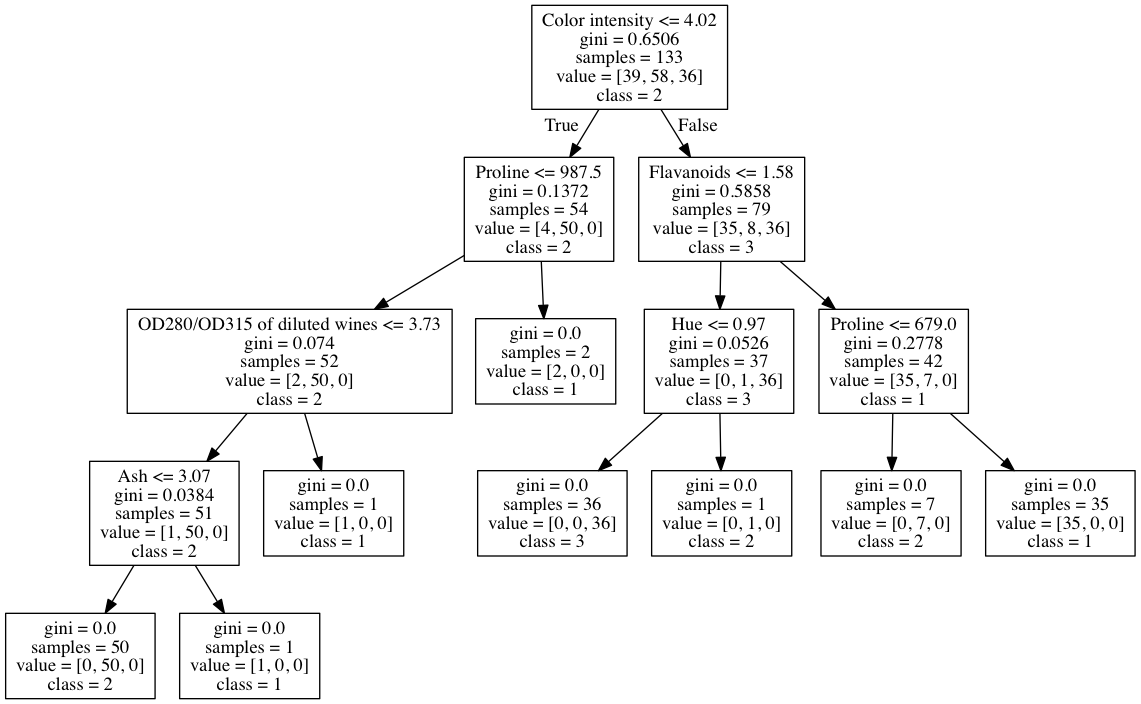

In [43]:
##Plotting the decision tree##
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=wine_Df.columns[1:],  
                         class_names=['1','2','3'])  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

# Problem 5

In [44]:
##Loading the data into a DataFrame##
AHW_DF=pd.read_csv('../Data/AHW_1.csv')
AHW_DF.head()

,Total,Sport,Age,Height,Weight,Sex
0,0,Judo,23,170,60,M
1,0,Athletics,33,193,125,M
2,0,Athletics,30,187,76,M
3,0,Boxing,24,NaN,NaN,M
4,0,Athletics,26,178,85,F


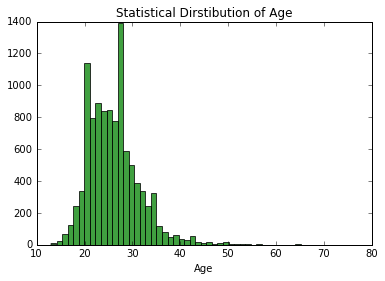

count    10384.000000
mean        26.068856
std          5.440561
min         13.000000
25%         22.000000
50%         25.000000
75%         29.000000
max         71.000000
Name: Age, dtype: float64


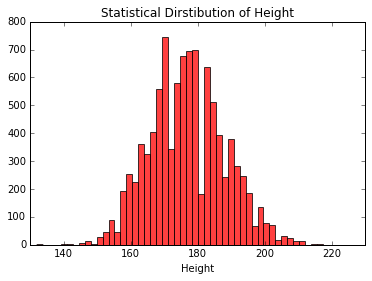

count    9823.000000
mean      176.907869
std        11.295433
min       132.000000
25%       169.000000
50%       177.000000
75%       185.000000
max       221.000000
Name: Height, dtype: float64


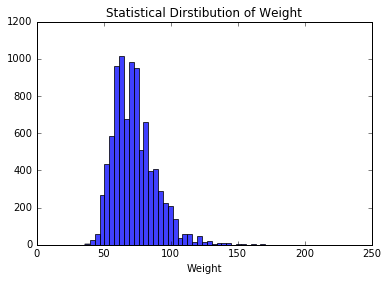

count    9104.000000
mean       72.852812
std        16.067462
min        36.000000
25%        61.000000
50%        70.000000
75%        81.000000
max       218.000000
Name: Weight, dtype: float64


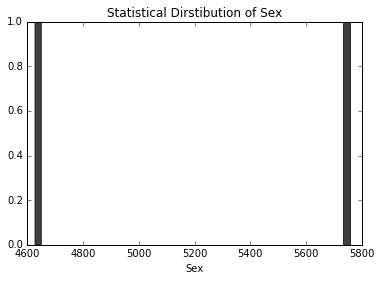

count     10384
unique        2
top           M
freq       5756
Name: Sex, dtype: object


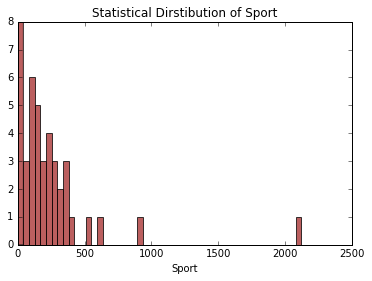

count         10384
unique           42
top       Athletics
freq           2119
Name: Sport, dtype: object


In [58]:
##Function to plot the histogram of variables and give the statistical summary##
def stat_dist (DF, var, color):
    if (var=='Sex' or var=='Sport'):
        plt.hist(DF[var].dropna().value_counts(), 50, facecolor=color, alpha=0.75)
    else:
        plt.hist(DF[var].dropna(), 50, facecolor=color, alpha=0.75)
    plt.xlabel(var)
    plt.title('Statistical Dirstibution of '+var)
    plt.show()
    print AHW_DF[var].describe()
##statistical distributions of variables using no class##
stat_dist(AHW_DF, 'Age', 'green')
stat_dist(AHW_DF, 'Height', 'red')
stat_dist(AHW_DF, 'Weight', 'blue')
stat_dist(AHW_DF, 'Sex', 'black')
stat_dist(AHW_DF, 'Sport', 'brown')

In [62]:
##How much missing data is there?##
print "Number of missing data per variables is:\n", AHW_DF.isnull().sum()

Number of missing data per variables is:
Total        0
Sport        0
Age          0
Height     561
Weight    1280
Sex          0
dtype: int64


In [63]:
##Function to give the distributions differences by gender##   
def plot_feat_male_femal (AHW_DF, attr):
    AHW_DF_Male=AHW_DF.ix[AHW_DF['Sex']=='M']
    AHW_DF_Female=AHW_DF.ix[AHW_DF['Sex']=='F']
    if (attr!='Sport'):
        plt.hist(AHW_DF_Male[attr].dropna().values, 50, facecolor='green', alpha=0.5, label='Male')
        plt.hist(AHW_DF_Female[attr].dropna().values, 50, facecolor='red', alpha=0.5, label='Female')
    elif (attr=='Sport'):
        plt.hist(AHW_DF_Male[attr].dropna().value_counts(), 50, facecolor='green', alpha=0.5, label='Male')
        plt.hist(AHW_DF_Female[attr].dropna().value_counts(), 50, facecolor='red', alpha=0.5, label='Female')
    plt.xlabel(attr)
    plt.legend()
    plt.show()
    print "Male statistics for",attr, "is:/n", AHW_DF_Male[attr].describe()
    print "Female statistics for",attr, "is:/n", AHW_DF_Female[attr].describe()


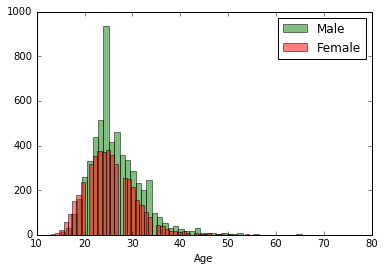

Male statistics for Age is:/n count    5756.000000
mean       26.562022
std         5.486685
min        15.000000
25%        23.000000
50%        26.000000
75%        29.000000
max        71.000000
Name: Age, dtype: float64
Female statistics for Age is:/n count    4628.000000
mean       25.455488
std         5.319810
min        13.000000
25%        22.000000
50%        25.000000
75%        29.000000
max        57.000000
Name: Age, dtype: float64


In [64]:
plot_feat_male_femal (AHW_DF, 'Age')

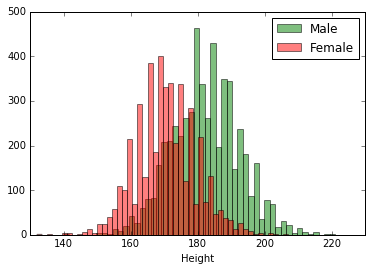

Male statistics for Height is:/n count    5396.000000
mean      182.377131
std        10.101097
min       140.000000
25%       175.000000
50%       182.000000
75%       189.000000
max       221.000000
Name: Height, dtype: float64
Female statistics for Height is:/n count    4427.000000
mean      170.241473
std         8.823018
min       132.000000
25%       165.000000
50%       170.000000
75%       176.000000
max       207.000000
Name: Height, dtype: float64


In [65]:
plot_feat_male_femal (AHW_DF, 'Height')

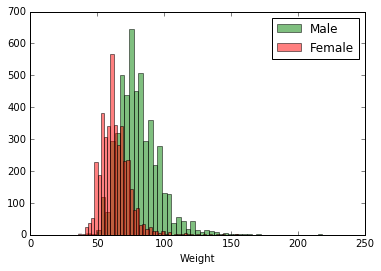

Male statistics for Weight is:/n count    5055.000000
mean       80.575865
std        15.399897
min        42.000000
25%        70.000000
50%        78.000000
75%        89.000000
max       218.000000
Name: Weight, dtype: float64
Female statistics for Weight is:/n count    4049.000000
mean       63.210916
std        10.815807
min        36.000000
25%        56.000000
50%        62.000000
75%        69.000000
max       155.000000
Name: Weight, dtype: float64


In [66]:
plot_feat_male_femal (AHW_DF, 'Weight')

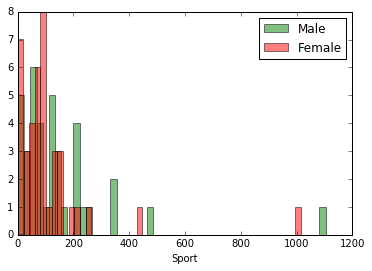

Male statistics for Sport is:/n count          5756
unique           38
top       Athletics
freq           1104
Name: Sport, dtype: object
Female statistics for Sport is:/n count          4628
unique           40
top       Athletics
freq           1015
Name: Sport, dtype: object


In [67]:
plot_feat_male_femal (AHW_DF, 'Sport')

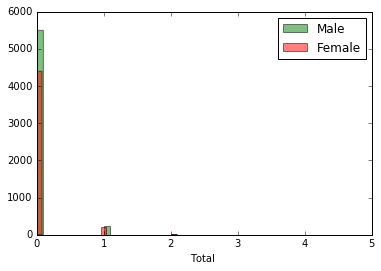

Male statistics for Total  is:/n count    5756.000000
mean        0.048645
std         0.238872
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: Total , dtype: float64
Female statistics for Total  is:/n count    4628.000000
mean        0.056612
std         0.263461
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Total , dtype: float64


In [68]:
plot_feat_male_femal (AHW_DF, 'Total ')

**Are any of the variables different for male vs. female athletes?**

*Only Height and Weight are significantly different between females vs males, where male athletes tend to be taller and heavier than femal athletes*

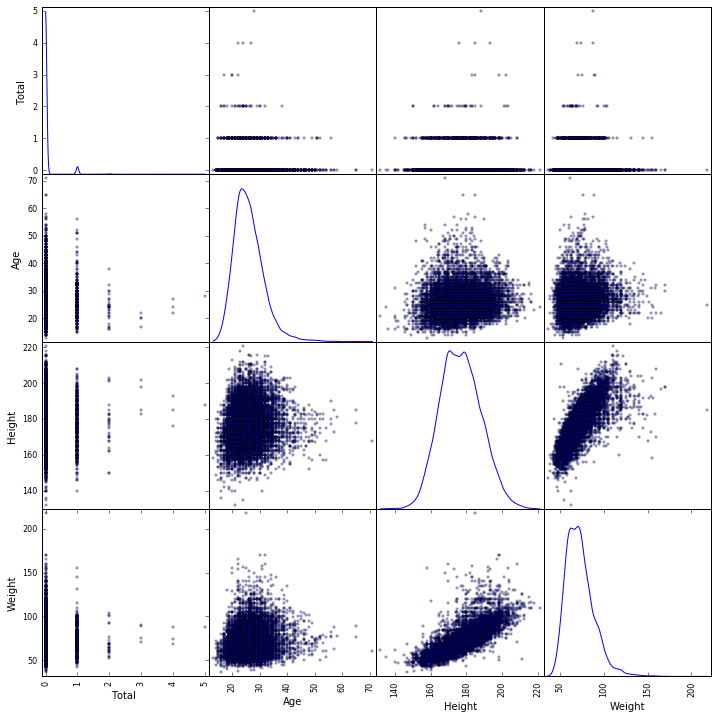

In [71]:
##Are there any ‘high’ correlations between variables?##
scatter_matrix(AHW_DF, alpha=0.3, figsize=(12, 12), diagonal='kde')
plt.show()

**Are there any ‘high’ correlations between variables?**

*As it can be seen from the scatter plots above, the variables Height and Weights are highly correlated.*

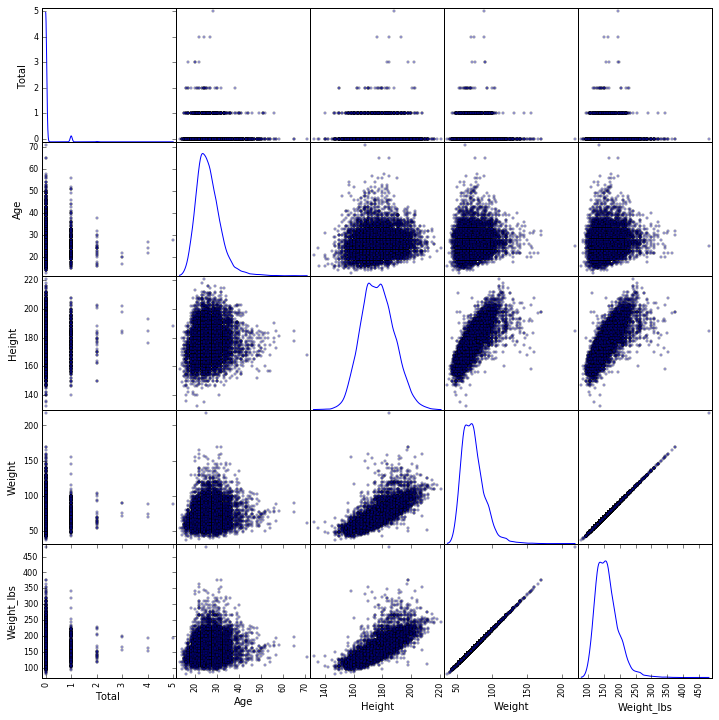

In [72]:
##Create a new variable for the weight in lbs and check out the correlations again##
AHW_DF['Weight_lbs']=AHW_DF['Weight']*2.20462
scatter_matrix(AHW_DF, alpha=0.3, figsize=(12, 12), diagonal='kde')
plt.show()

**Create a new variable for the weight in lbs.  Check out the correlations again.  Do you notice any changes?**

*No change in correlations are obseverd after converting the Weight from kilo to pounds*

In [73]:
##Remove one of the weight variables##
AHW_DF.drop(['Weight_lbs'], axis=1, inplace=True)

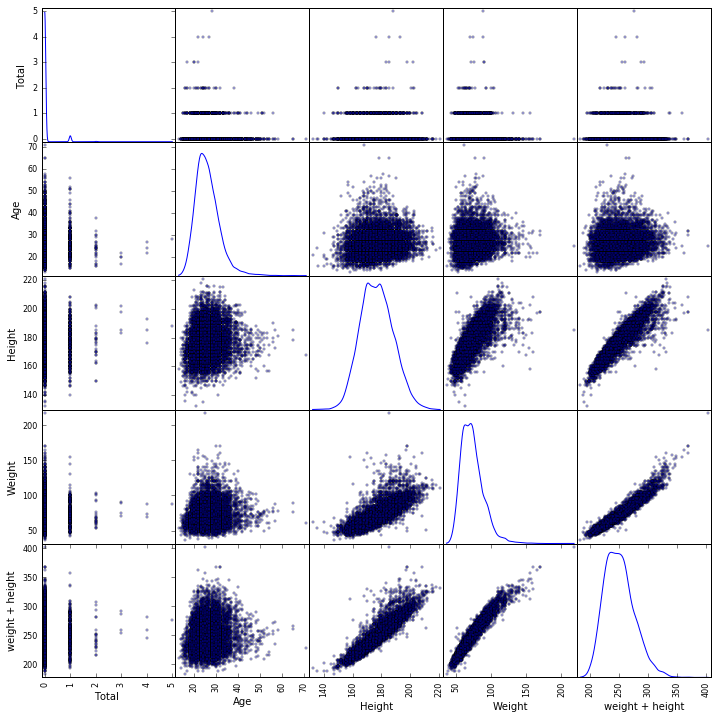

In [74]:
##Add new variable weight + height. Visualize scatter plot.  Is this a useful variable?##
AHW_DF['weight + height']=AHW_DF['Weight']+AHW_DF['Height']
scatter_matrix(AHW_DF, alpha=0.3, figsize=(12, 12), diagonal='kde')
plt.show()

**Add new variable weight + height.  Visualize scatter plot.  Is this a useful variable? **

*height+weight doesn't seem to be a useful variable as it is extremely correlated to both height and weight and doesn't yeild any new information *

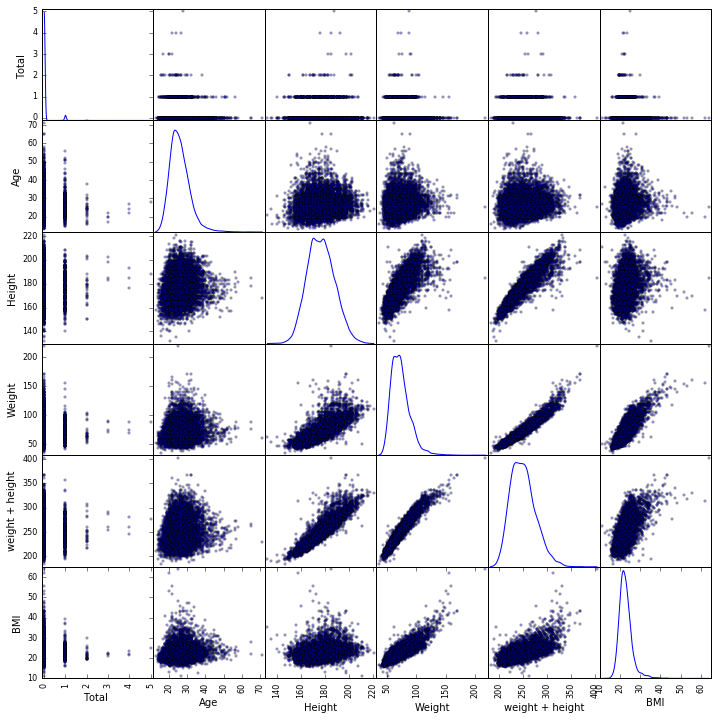

In [75]:
##Repeat the same exercise for Body Mass Index defined as Mass (kg)/Height(m)##
AHW_DF['BMI']=AHW_DF['Weight']/pow(AHW_DF['Height']/100,2)
scatter_matrix(AHW_DF, alpha=0.3, figsize=(12, 12), diagonal='kde')
plt.show()

**Repeat the same exercise for Body Mass Index defined as Mass (kg)/Height(m) 2 (Note: Weight already in Kg. and Height is in cm).  Is this a useful variable?**

*BMI seems to be a useful variable as it is only correlated with Weight and doesn't have much of correlation with Height and hence it can yield new information.*

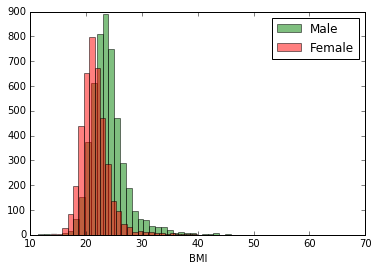

Male statistics for BMI is:/n count    5017.000000
mean       23.961976
std         3.387829
min        11.455268
25%        21.913806
50%        23.510204
75%        25.237205
max        63.696129
Name: BMI, dtype: float64
Female statistics for BMI is:/n count    4021.000000
mean       21.637999
std         2.820028
min        13.774105
25%        20.047446
50%        21.296296
75%        22.758307
max        62.089409
Name: BMI, dtype: float64


In [76]:
##Plot the BMI of the athletes##
plot_feat_male_femal (AHW_DF, 'BMI')

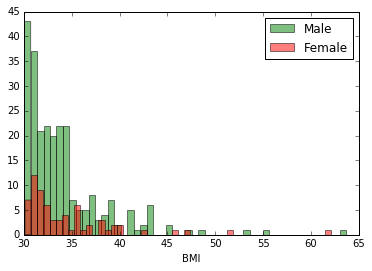

Male statistics for BMI is:/n count    249.000000
mean      34.003962
std        4.447866
min       30.024445
25%       31.020408
50%       32.770513
75%       34.717839
max       63.696129
Name: BMI, dtype: float64
Female statistics for BMI is:/n count    67.000000
mean     34.588865
std       5.437288
min      30.116213
25%      31.242326
50%      32.653061
75%      35.623896
max      62.089409
Name: BMI, dtype: float64


In [79]:
##Are there any obese athletes? Male of Female? ##
obese_DF=AHW_DF.ix[AHW_DF['BMI']>30]
plot_feat_male_femal (obese_DF, 'BMI')

**Are there any obese athletes? Male of Female?**

*There are much more obese athlete men than obese athlete women.*

In [80]:
##Split data by sport##
AHW_DF_split_sport=AHW_DF.groupby('Sport').mean()[['Age','Height','Weight','BMI']]

In [81]:
##Function to plot the bar plots per sport##
def sport_bar_plot(AHW_DF_split_sport, attr):
    index=np.arange(AHW_DF_split_sport.shape[0])
    bar_width = 0.5
    figure(figsize=(20,8))
    plt.bar(index, AHW_DF_split_sport[attr])
    plt.xticks(index + bar_width, AHW_DF_split_sport.index,rotation=80)
    plt.show()

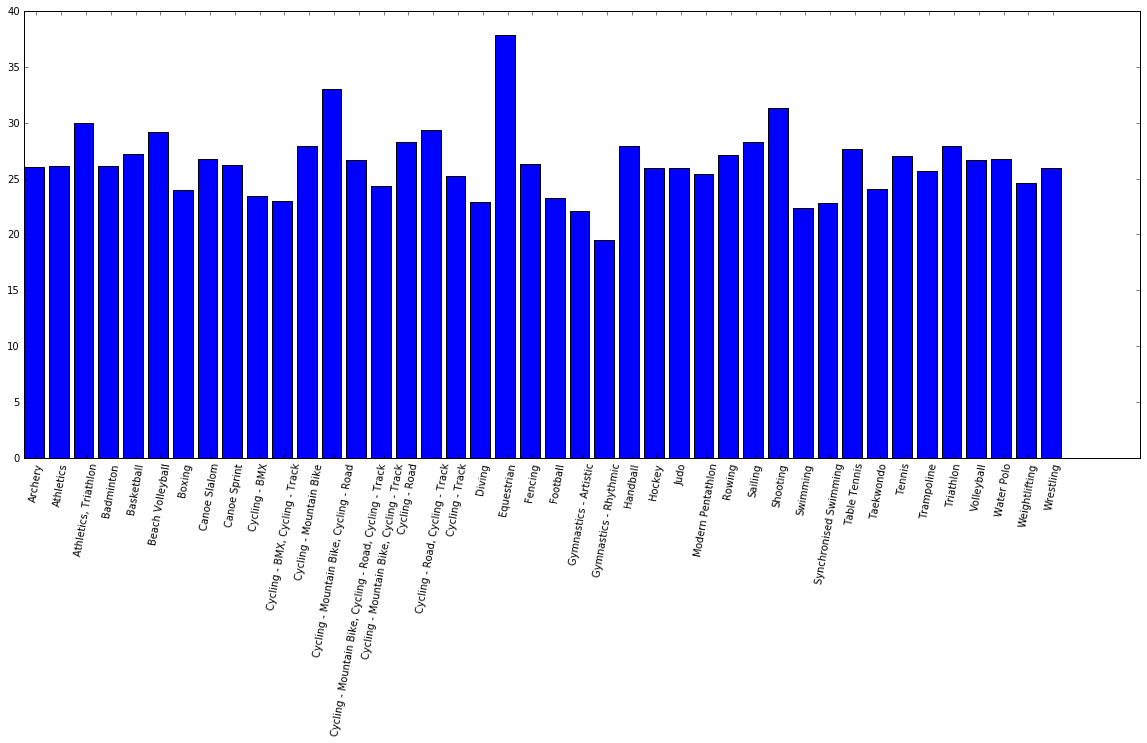

In [82]:
sport_bar_plot(AHW_DF_split_sport, 'Age')

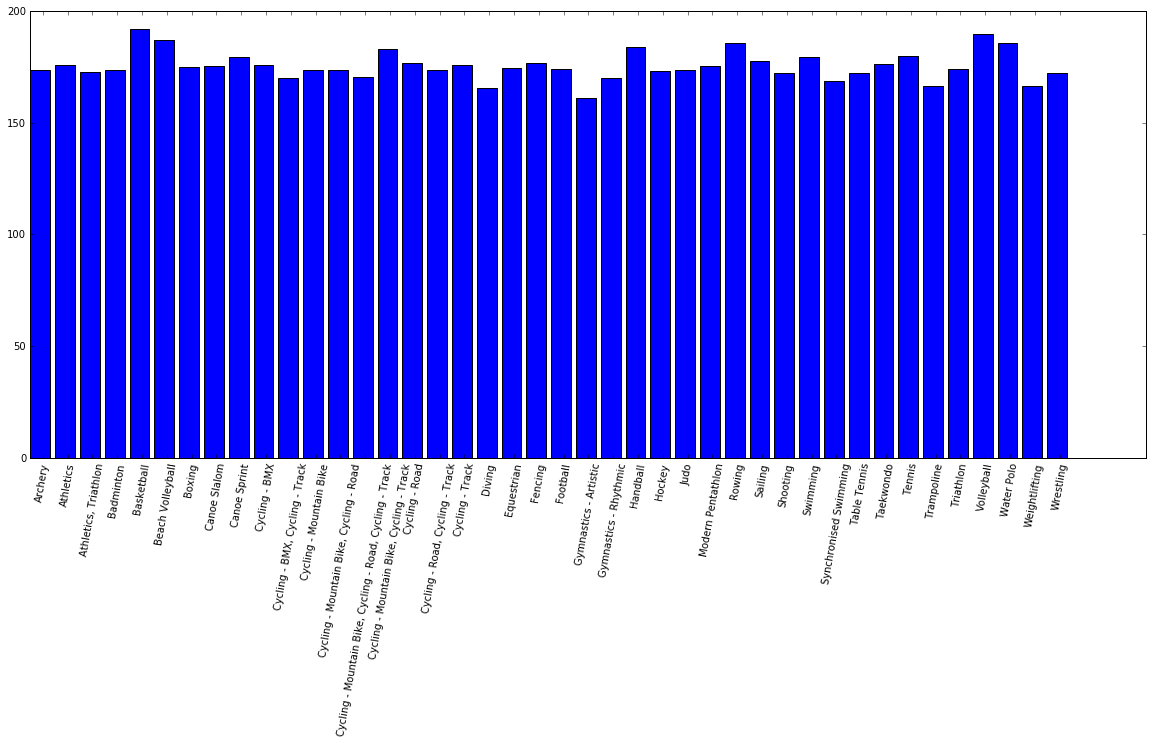

In [83]:
sport_bar_plot(AHW_DF_split_sport, 'Height')

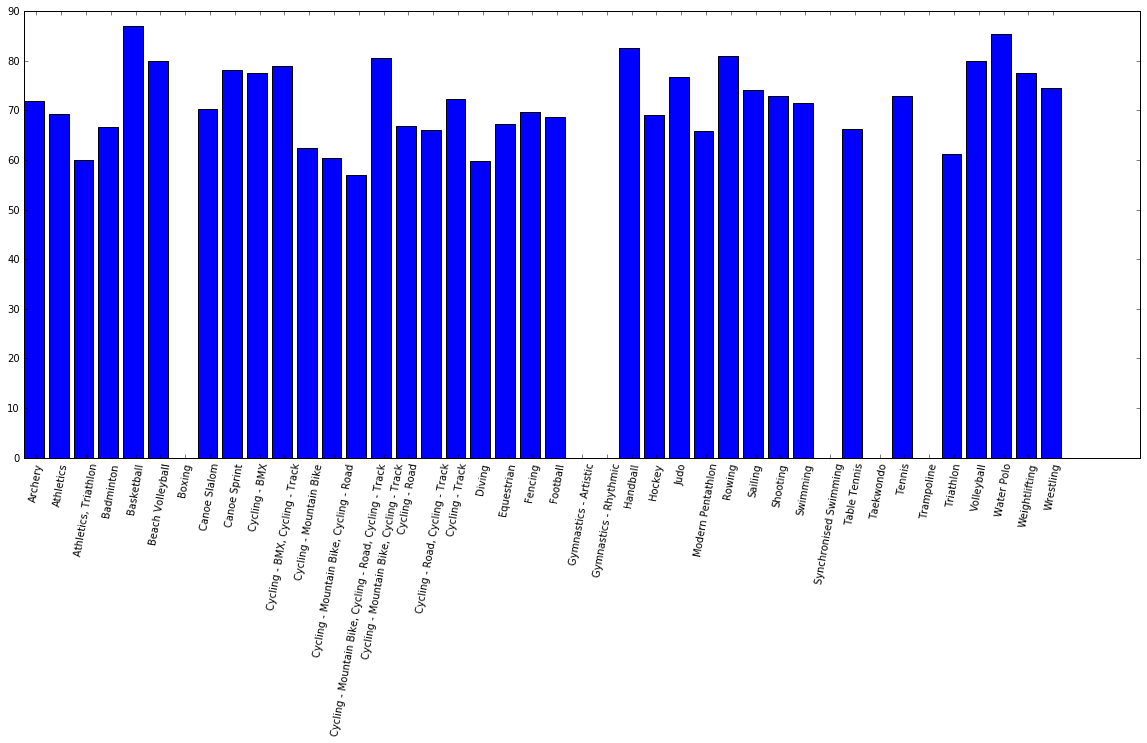

In [84]:
sport_bar_plot(AHW_DF_split_sport, 'Weight')

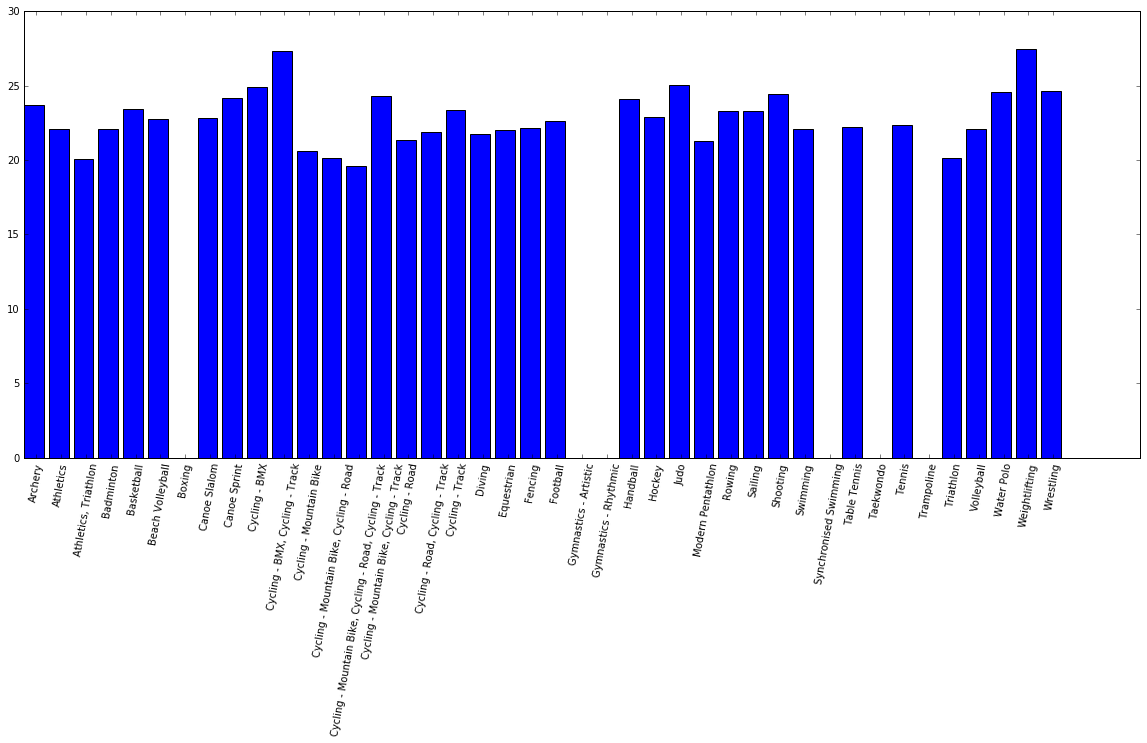

In [85]:
sport_bar_plot(AHW_DF_split_sport, 'BMI')

**Split data by sport.  What can you conclude based on the split?**

- Wrestling athletes have the highest BMI and athletes who play sports like cycling have the lowest BMI
- Athletes playing Basketball and Waterpolo have the highest Weight and those who do road and mountain cycling have the lowest weight.
- Athletes playing Basketball and Volleyball have the highest height and gymnasts have the lowest height.
- The oldest athletes are the ones playing equestrian and the yougest ones are the gymnasts.